In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as graph
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm, trange
graph.style.use('fivethirtyeight')
graph.rcParams['lines.linewidth'] = 1

(5000, 2) (5000,)


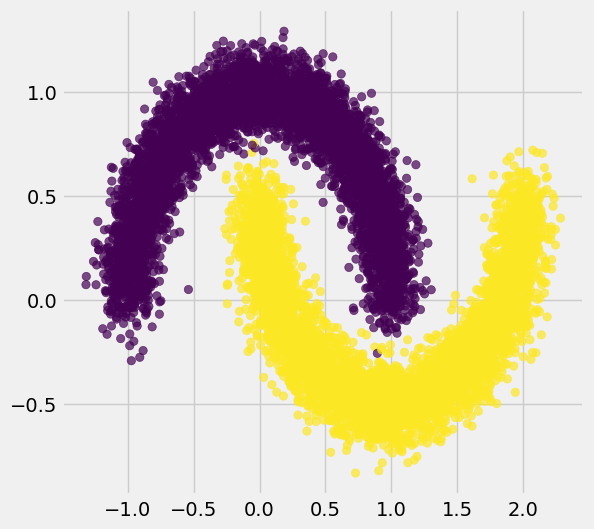

In [2]:
def plot_decision_boundary(model, x, y, extrapolation=1.2):
    x_min, x_max = x[:, 0].min() * extrapolation, x[:, 0].max() * extrapolation
    y_min, y_max = x[:, 1].min() * extrapolation, x[:, 1].max() * extrapolation

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    pred = model.forward(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    pred = pred.reshape(xx.shape)
    pred = pred.detach().numpy()

    graph.contourf(xx, yy, pred, alpha=0.4)


# Toy Data
# x, y = make_circles(n_samples=10_000, noise=0.1, factor=0.6)
x, y = make_moons(10_000, noise=0.1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)
print(x_train.shape, y_train.shape)

graph.figure(figsize=(6, 6))
graph.scatter(x[:, 0], x[:, 1], c=y, alpha=0.7)
graph.show()

# Basic - Deep Logistic Regression

In [3]:
class DeepLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DeepLogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.activation1 = nn.ELU()

        self.fc2 = nn.Linear(4, 4)
        self.activation2 = nn.ELU()

        self.output_layer = nn.Linear(4, 1)
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)

        x = self.fc2(x)
        x = self.activation2(x)

        x = self.output_layer(x)
        x = self.output_activation(x)
        return x

In [4]:
deep_lr = DeepLogisticRegression(2, 1)
optimizer = torch.optim.Adam(deep_lr.parameters(), lr=0.01)
loss_func = nn.BCELoss()

# Training loop
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.reshape(-1, 1)).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val.reshape(-1, 1)).float()

In [5]:
n_epochs = int(10e3)
hist_lr = []
best_epoch = 0
best_loss = float('inf')
iterator = trange(n_epochs)
for epoch in iterator:
    # Forward pass
    y_hat = deep_lr.forward(x_train)
    loss_i = loss_func(y_hat, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss_i.backward()
    optimizer.step()

    # Validation and Logging
    with torch.inference_mode():
        hist_lr.append(loss_func(deep_lr.forward(x_val), y_val))
        iterator.set_description(f'i: {epoch:,} | loss: {hist_lr[-1].detach().numpy():.8f}')
        if hist_lr[-1] < best_loss:
            best_loss = hist_lr[-1]
            best_epoch = epoch
        elif (epoch - best_epoch) > 10:
            print(f'Early stopping at epoch {epoch}')
            break


  0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping at epoch 3556


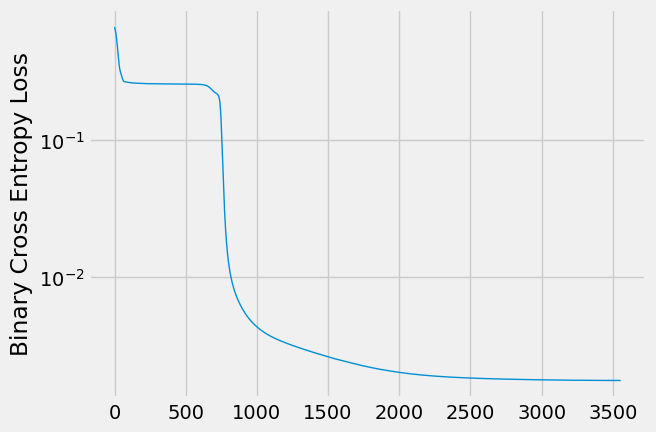

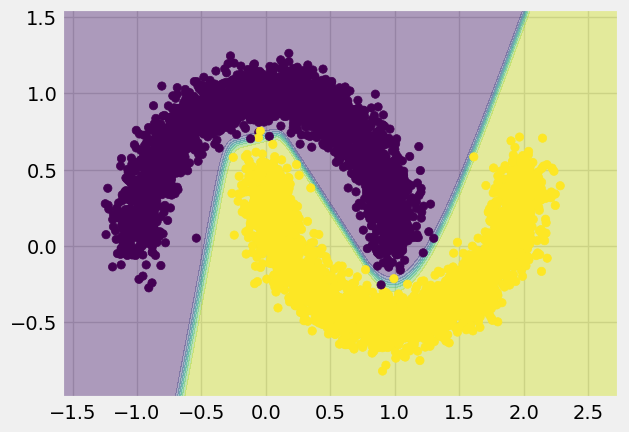

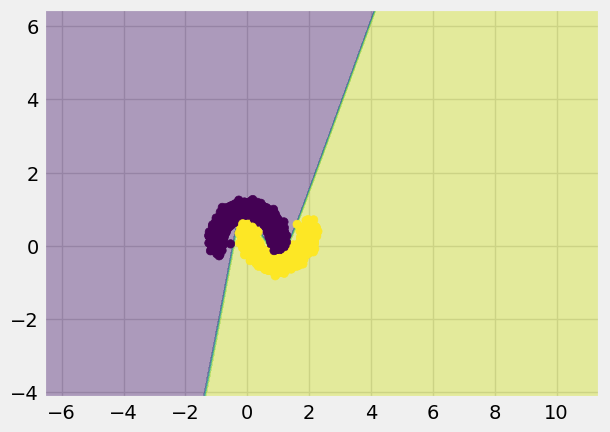

In [6]:
# Results
graph.plot(np.array([t.detach().numpy() for t in hist_lr]))
graph.yscale('log')
graph.ylabel('Binary Cross Entropy Loss')
graph.show()

plot_decision_boundary(deep_lr, x, y)
graph.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train)
graph.show()

plot_decision_boundary(deep_lr, x, y, extrapolation=5)
graph.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train)
graph.show()

# Advanced - RBF Model

$$RBF(x) = \varphi(x) = e^{-\beta ||x - \mu_{center}||^2}$$

In the hidden layer the neural network is the number of normal distributions that will be place to explain the data.

In [7]:
class RBFLayer(nn.Module):
    def __init__(self, size_in, n_rbfs, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(RBFLayer, self).__init__()
        self.size_in = size_in
        self.n_rbfs = n_rbfs  # This is also the size of the output layer

        # Parameters
        self.centers = nn.Parameter(torch.Tensor(n_rbfs, size_in))
        self.betas = nn.Parameter(torch.Tensor(n_rbfs))

        # Initialize parameters
        nn.init.kaiming_uniform_(self.centers, a=0, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.betas, 1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # RBF activation function
        # \varphi = exp[-\beta * ||x-\mu||^2]
        diff = x.unsqueeze(1) - self.centers.unsqueeze(0)
        return torch.exp(-self.betas * torch.norm(diff, 2, dim=2))



In [8]:
class RBFModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RBFModel, self).__init__()
        self.rbf_layer = RBFLayer(input_size, n_rbfs=10)

        self.output_layer = nn.LazyLinear(1)
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.rbf_layer(x)

        x = self.output_layer(x)
        x = self.output_activation(x)
        return x

In [9]:
rbf_model = RBFModel(2, 1)
optimizer = torch.optim.Adam(rbf_model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

print('='*60)
rbf_model.forward(x_train)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[0.4216],
        [0.3877],
        [0.3912],
        ...,
        [0.4288],
        [0.4321],
        [0.4349]], grad_fn=<SigmoidBackward0>)

In [10]:
# Implement training loop and losses etc
n_epochs = int(10e3)
hist = []
best_epoch = 0
best_loss = float('inf')
iterator = trange(n_epochs)
for epoch in iterator:
    # Forward pass
    y_hat = rbf_model.forward(x_train)
    loss_i = loss_func(y_hat, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss_i.backward()
    optimizer.step()

    # Validation and Logging
    with torch.inference_mode():
        hist.append(loss_func(rbf_model.forward(x_val), y_val))
        iterator.set_description(f'i: {epoch:,} | loss: {hist[-1].detach().numpy():.8f}')
        if hist[-1] < best_loss:
            best_loss = hist[-1]
            best_epoch = epoch
        elif (epoch - best_epoch) > 10:
            print(f'Early stopping at epoch {epoch}')
            break


  0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping at epoch 7409


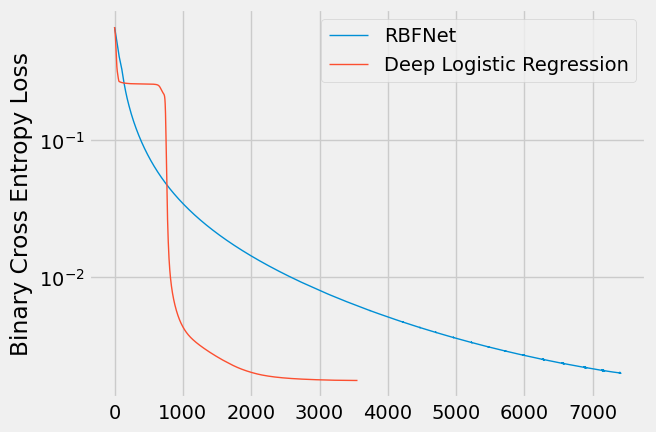

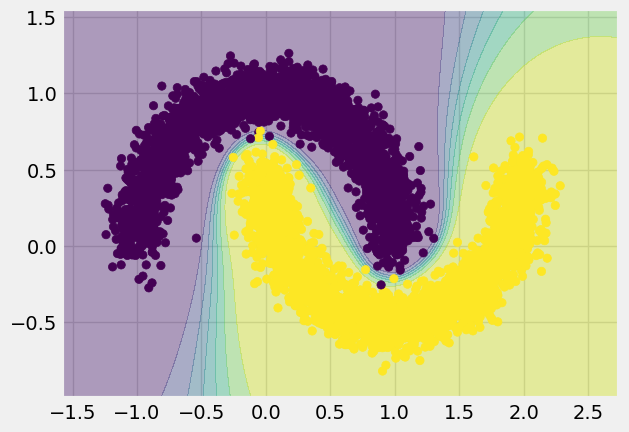

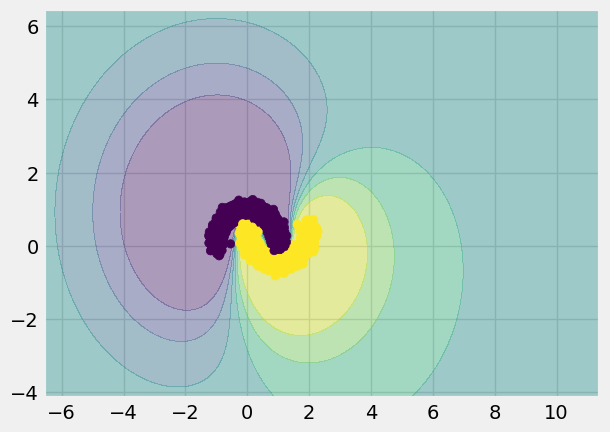

In [11]:
# Results
graph.plot(np.array([t.detach().numpy() for t in hist]), label='RBFNet')
graph.plot(np.array([t.detach().numpy() for t in hist_lr]), label='Deep Logistic Regression')
graph.yscale('log')
graph.ylabel('Binary Cross Entropy Loss')
graph.legend()
graph.show()

plot_decision_boundary(rbf_model, x, y)
graph.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train)
graph.show()

plot_decision_boundary(rbf_model, x, y, extrapolation=5)
graph.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train)
graph.show()

_Stephen Anthony Rose_